In [ ]:
import os 
import pandas as pd
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img
import seaborn as sns
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Dense,Activation,concatenate, AveragePooling2D, Flatten, Dropout, BatchNormalization, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import cv2
from PIL import Image
from pathlib import Path
from imutils import paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path_train = "/content/drive/MyDrive/Covid Xray/CovidDataset/Train"
path_val = "/content/drive/MyDrive/Covid Xray/CovidDataset/Val"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


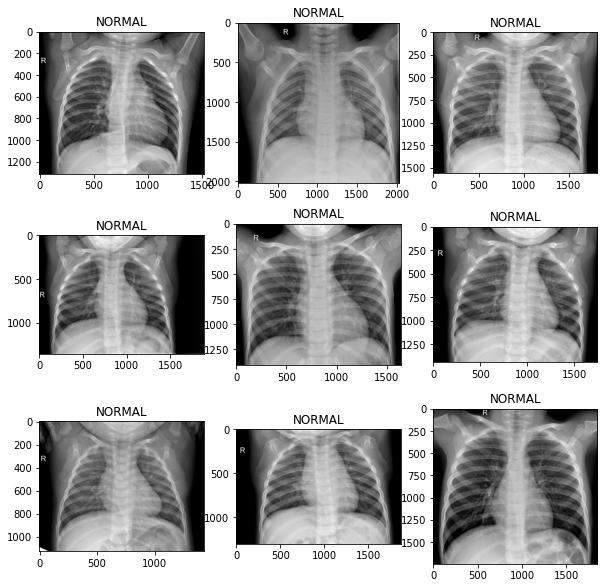

In [ ]:
Normalimages = os.listdir(path_train + "/Normal")
COVID19images = os.listdir(path_train + "/Covid")
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(path_train + "/Normal",Normalimages[i])),cmap='gray')
    plt.title("NORMAL")
plt.show()

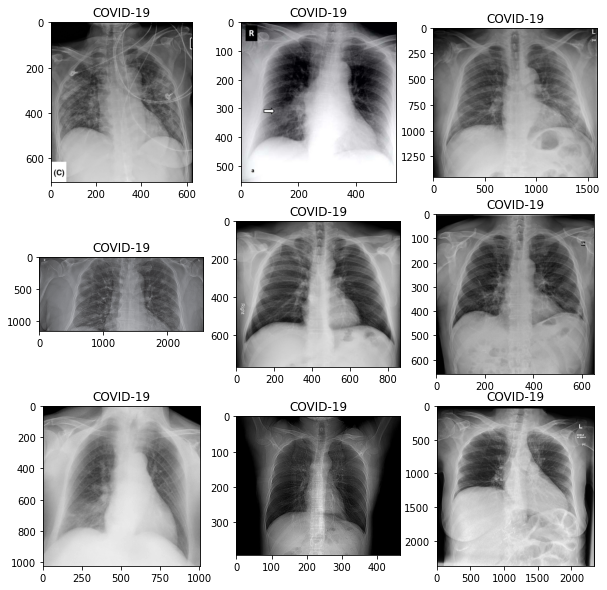

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(path_train + "/Covid",COVID19images[i])),cmap='gray')
    plt.title("COVID-19")
plt.show()

In [ ]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
trainPaths = list(paths.list_images(path_train))
valPaths = list(paths.list_images(path_val))

In [ ]:
 len(valPaths)

60

In [ ]:
#taking out labels for one img path
trainPaths[2].split(os.path.sep)[-2]

'Covid'

In [ ]:
trainData = []
trainLabels = []

# loop over the image paths
for img in trainPaths:
# extract the class label from the filename
    label = img.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    #preprocess image by converting to RGB channel ordering, and resizing it to 224×224 pixels
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    trainData.append(image)
    trainLabels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
trainData = np.array(trainData) / 255.0
trainLabels = np.array(trainLabels)

In [ ]:
valData = []
valLabels = []

# loop over the image paths
for img in valPaths:
# extract the class label from the filename
    label = img.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    #preprocess image by converting to RGB channel ordering, and resizing it to 224×224 pixels
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    valData.append(image)
    valLabels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
valData = np.array(valData) / 255.0
valLabels = np.array(valLabels)

In [ ]:
#number of Train data after image preprocessing
len(trainData),len(trainLabels)

(224, 224)

In [ ]:
#number of val data after image preprocessing
len(valData),len(valLabels)

(60, 60)

In [ ]:
# perform one-hot encoding on the train labels
lb = LabelBinarizer()
trainLabels = lb.fit_transform(trainLabels)
trainLabels = to_categorical(trainLabels)

In [ ]:

# perform one-hot encoding on the test labels
valLabels = lb.fit_transform(valLabels)
valLabels = to_categorical(valLabels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, valX, trainY, valY) = train_test_split(trainData, trainLabels, test_size=0.30, stratify=trainLabels, random_state=28)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=20, fill_mode="nearest")

In [ ]:
valdat = np.argmax(valLabels, axis=1)
valdat[8]

0

In [ ]:
bmodel=tf.keras.applications.DenseNet169(
    weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)),pooling='avg'
)
headModel = bmodel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=bmodel.input, outputs=headModel)

for layer in bmodel.layers:
	layer.trainable = False

51888128/51877672 [==============================] - 2s 0us/step


In [ ]:
INIT_LR = 1e-3
EPOCHS = 30
BS = 32

In [ ]:
# training
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
r = model.fit_generator(trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(valX, valY),
    validation_steps=len(valX) // BS,
    epochs=EPOCHS)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
4/4 [==============================] - 38s 4s/step - loss: 0.6702 - accuracy: 0.7097 - val_loss: 0.3941 - val_accuracy: 0.8971
Epoch 2/30
4/4 [==============================] - 3s 653ms/step - loss: 0.3660 - accuracy: 0.9219 - val_loss: 0.2224 - val_accuracy: 1.0000
Epoch 3/30
4/4 [==============================] - 4s 993ms/step - loss: 0.2188 - accuracy: 0.9597 - val_loss: 0.1458 - val_accuracy: 1.0000
Epoch 4/30
4/4 [==============================] - 4s 1s/step - loss: 0.1777 - accuracy: 0.9677 - val_loss: 0.0963 - val_accuracy: 1.0000
Epoch 5/30
4/4 [==============================] - 4s 1s/step - loss: 0.1291 - accuracy: 0.9839 - val_loss: 0.0694 - val_accuracy: 1.0000
Epoch 6/30
4/4 [==============================] - 6s 1s/step - loss: 0.1057 - accuracy: 0.9839 - val_loss: 0.0525 - val_accuracy: 1.0000
Epoch 7/30
4/4 [==============================] - 5s 880ms/step - loss: 0.1052 - accuracy: 0.9839 - val_loss: 0.0415 - val_accuracy: 1.0000
Epoch 8/30
4/4 [===============

In [ ]:
model.save("/content/drive/MyDrive/DenseNet.h5")

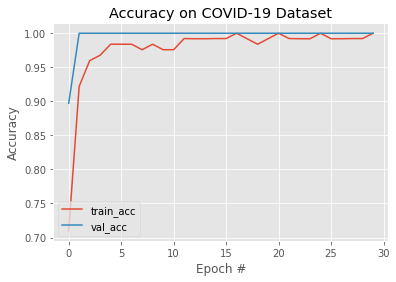

In [ ]:
 # plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()

plt.plot(np.arange(0, N), r.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), r.history["val_accuracy"], label="val_acc")
plt.title("Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

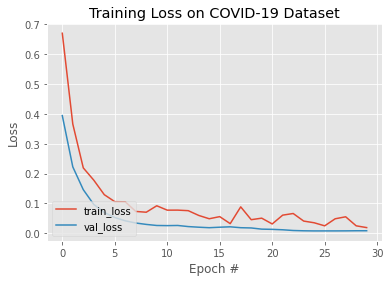

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), r.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), r.history["val_loss"], label="val_loss")

plt.title("Training Loss on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs2 = model.predict(trainX, batch_size=BS)

# index of the
# label with corresponding largest predicted probability

predIdxs2 = np.argmax(predIdxs2, axis=1)

# classification report
print(classification_report(trainY.argmax(axis=1), predIdxs2,
	target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       Covid       0.99      1.00      0.99        78
      Normal       1.00      0.99      0.99        78

    accuracy                           0.99       156
   macro avg       0.99      0.99      0.99       156
weighted avg       0.99      0.99      0.99       156



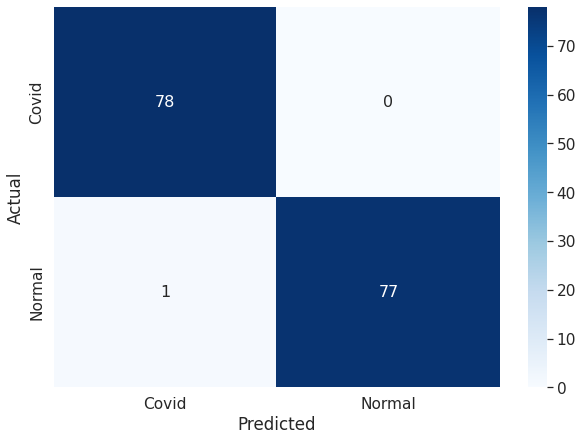

In [ ]:
dat = confusion_matrix(trainY.argmax(axis=1), predIdxs2)
df_cm = pd.DataFrame(dat, columns=lb.classes_, index = lb.classes_)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs1= model.predict(valData)

# index of the
# label with corresponding largest predicted probability

predIdxs1= np.argmax(predIdxs1, axis=1)
valdat = np.argmax(valLabels, axis=1)
#print(valdat.shape, predIdxs1.shape)
#print(valdat[:5], predIdxs1[:5]
# classification report
print(classification_report(valdat, predIdxs1,target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       Covid       0.97      1.00      0.98        30
      Normal       1.00      0.97      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



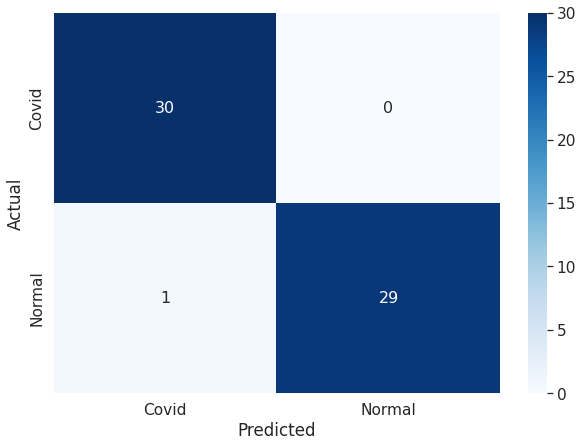

In [ ]:
data = confusion_matrix(valdat, predIdxs1)
df_cm = pd.DataFrame(data, columns=lb.classes_, index = lb.classes_)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})

In [ ]:
total = sum(sum(data))
acc = (data[0, 0] + data[1, 1]) / total
sensitivity = data[0, 0] / (data[0, 0] + data[0, 1])
specificity = data[1, 1] / (data[1, 0] + data[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("accuracy: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

accuracy: 0.9833
sensitivity: 1.0000
specificity: 0.9667


In [ ]:
model1=load_model("/content/drive/MyDrive/DenseNet.h5")

In [ ]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
score=model1.evaluate(valX,valY,verbose=0)

In [ ]:
score[1]*100

100.0

In [ ]:
score[1]

1.0

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs2= model1.predict(valData)

# index of the
# label with corresponding largest predicted probability

predIdxs2= np.argmax(predIdxs2, axis=1)
valdat = np.argmax(valLabels, axis=1)
#print(valdat.shape, predIdxs1.shape)
#print(valdat[:5], predIdxs1[:5]
# classification report
print(classification_report(valdat, predIdxs2,target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       Covid       0.97      1.00      0.98        30
      Normal       1.00      0.97      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



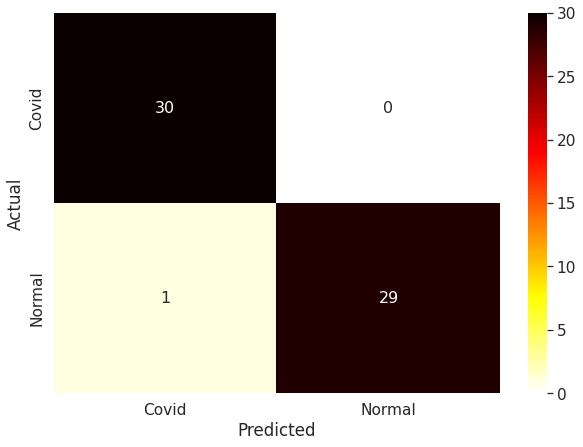

In [ ]:
cm = confusion_matrix(valdat, predIdxs2)
df_cm = pd.DataFrame(cm, columns=lb.classes_, index = lb.classes_)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="hot_r", annot=True,annot_kws={"size": 16})

In [ ]:
total = sum(sum(data))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

acc: 0.9833
sensitivity: 1.0000
specificity: 0.9667


In [ ]:
def detect(img):
  pimage = cv2.imread(img)
  pimage = cv2.cvtColor(pimage, cv2.COLOR_BGR2RGB)
  pimage = cv2.resize(pimage, (224, 224))
  pimgdata = np.array(pimage) / 255.0
  image_batch = np.expand_dims(pimgdata,axis=0)
  pred_new= model.predict(image_batch)
  pred_new= np.argmax(pred_new, axis=1)
  if pred_new==1:
      print("NORMAL")
  else:
      print("COVID-19")


In [ ]:
imgpath = '/content/drive/MyDrive/Covid19/COVID/covid-test.jpeg'
detect(imgpath)

COVID-19
